<a href="https://colab.research.google.com/github/IamShivamJaiswal/TrafficSignClassifer/blob/master/LeNetWithAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
f = open("cookie.txt",'w')
f.write("""
Paste your cookie here
""")
f.close()

How to download Kaggle dataset from command line?[Use this link](https://wdeback.gitlab.io/post/2018-03-08-how-to-download-kaggle-dataset-from-command-line/)

In [2]:
!wget -x -c --load-cookies cookie.txt https://www.kaggle.com/mahadevkonar/belgiumts-dataset/downloads/belgiumts-dataset.zip/1   -O belgiumts-dataset.zip

--2019-01-14 14:27:09--  https://www.kaggle.com/mahadevkonar/belgiumts-dataset/downloads/belgiumts-dataset.zip/1
Resolving www.kaggle.com (www.kaggle.com)... 23.96.207.25
Connecting to www.kaggle.com (www.kaggle.com)|23.96.207.25|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-datasets/10902/15203/belgiumts-dataset.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1547735229&Signature=SyVoVWDyryLp8r3veKoOr%2FSm0FOadm6okBG5wYUQHl9TaNlVbzU3%2FTsRwvS%2B8ttsBQR6nms36vm6q1YADELFFnB8f%2Fg5uEyWC3939bJX%2Bfs9mEYQf%2B%2Bz60fq4fKmxbv%2BgLgupNGzuAW%2B48YmWzvVIVnIjPHjL5zqZIEoVkRvUBtoJK%2B5sZj3b085YuPENgBfeRTXd5rCth1tQu8IhydVID70UQF8wzllCUp7AUWeTKE6GGJ7R7UUNnaEimyWWKUUVmeKnv8KkWtofjtZN4svao%2FuAO0XcoCmZp0vrV2D3%2Fi9KuiTMkKWJJmHy8%2BB87E45LSaIK%2B7Bf5Rd2yCYrt2yg%3D%3D [following]
--2019-01-14 14:27:09--  https://storage.googleapis.com/kaggle-datasets/10902/15203/belgiumts-dataset.zip?GoogleAccessId=web-data@

In [0]:
!unzip belgiumts-dataset.zip >> output.txt
!unzip BelgiumTSC_Testing.zip  -d data >> output.txt
!unzip BelgiumTSC_Training.zip  -d data >> output.txt

In [4]:
!cd data && ls

Testing  Training


In [5]:
import numpy as np
import pandas as pd

# imports needed for CNN
import csv
import cv2
import os, glob
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import time
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt

from subprocess import check_output

Using TensorFlow backend.


In [0]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = os.listdir(data_dir)
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    category = 0
    for d in directories:
        if (d != 'Readme.txt'):
            file_names = [os.path.join(data_dir + d, f) for f in os.listdir(data_dir + d) if f.endswith(".ppm")]
        else:
            continue
        for f in file_names:
            img = cv2.imread(f)
            imresize = cv2.resize(img, (32, 32))
            #grayimg = cv2.cvtColor(imresize,cv2.COLOR_RGB2GRAY)
            #grayimg=np.reshape(grayimg,(32,32,1))
            #plt.imshow(imresize)
            images.append(imresize)
            labels.append(category) 
        category += 1
    #Normalization
    images = np.array(images).astype('float32')
    images = images / 255.0
    #hot encoding
    labels = np.array(labels)
    #labels = to_categorical(labels,category)
    return images, labels

In [10]:
X_train, y_train = [],[]
X_train, y_train = load_data('data/Training/')
print (len(X_train))
print (len(y_train))

4575
4575


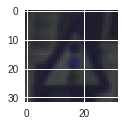

In [12]:
temp = -1
fig=plt.figure(figsize=(20, 20))
for i in range(0,y_train.shape[0]):
    if (np.argmax(y_train[i]) != temp):
        fig.add_subplot(10, 2, np.argmax(y_train[i]) + 1)
        plt.imshow(X_train[i])
        if (np.argmax(y_train[i]) >= 19):
            break
        temp = np.argmax(y_train[i])

In [13]:
X_test, y_test = [],[]
X_test, y_test = load_data('data/Testing/')
print (len(X_test),len(y_test))

2520 2520


shape in/out: (32, 32, 3) (32, 32, 3)


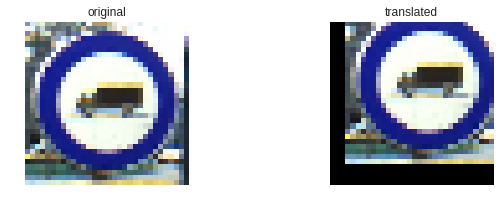

In [14]:
import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 5
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return np.reshape(dst,(32,32,3))

test_img = X_train[22]

test_dst = random_translate(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('translated')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 3) (32, 32, 3)


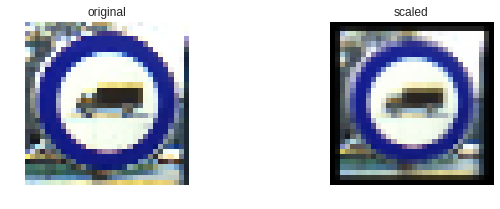

In [15]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-5,5)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return np.reshape(dst,(32,32,3))

test_dst = random_scaling(test_img)
    
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('scaled')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 3) (32, 32, 3)


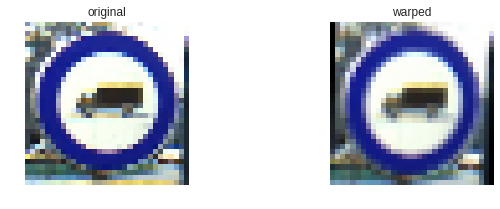

In [16]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(5) - 0.5
    rndx *= cols * 0.07   # this coefficient determines the degree of warping
    rndy = np.random.rand(5) - 0.5
    rndy *= rows * 0.07

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    return np.reshape(dst,(32,32,3))

test_dst = random_warp(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('warped')

print('shape in/out:', test_img.shape, test_dst.shape)

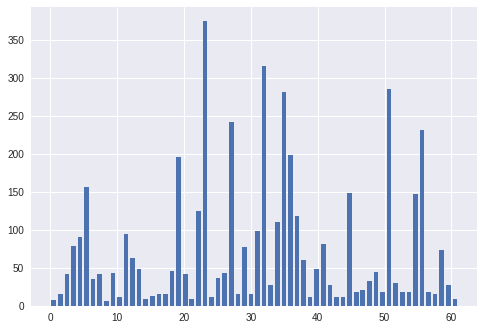

In [17]:
n_classes = 62
# histogram of label frequency (once again, before data augmentation)
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [18]:
X_train_normalized = np.copy(X_train)
y_train_normalized = np.copy(y_train)
print('X, y shapes:', X_train_normalized.shape, y_train_normalized.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train_normalized == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 150:
        for i in range(150 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(new_img)))
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train_normalized = np.concatenate((y_train_normalized, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train_normalized.shape)

X, y shapes: (4575, 32, 32, 3) (4575,)
0 : |----|----|----
1 : |----|----|---
2 : |----|----|
3 : |----|--
4 : |----|
5 : 
6 : |----|----|-
7 : |----|----|
8 : |----|----|----
9 : |----|----|
10 : |----|----|---
11 : |----|
12 : |----|---
13 : |----|----|
14 : |----|----|----
15 : |----|----|---
16 : |----|----|---
17 : |----|----|---
18 : |----|----|
19 : 
20 : |----|----|
21 : |----|----|----
22 : |--
23 : 
24 : |----|----|---
25 : |----|----|-
26 : |----|----|
27 : 
28 : |----|----|---
29 : |----|--
30 : |----|----|---
31 : |----|
32 : 
33 : |----|----|--
34 : |---
35 : 
36 : 
37 : |---
38 : |----|---
39 : |----|----|---
40 : |----|----|
41 : |----|-
42 : |----|----|--
43 : |----|----|---
44 : |----|----|---
45 : |
46 : |----|----|---
47 : |----|----|--
48 : |----|----|-
49 : |----|----|
50 : |----|----|---
51 : 
52 : |----|----|-
53 : |----|----|---
54 : |----|----|---
55 : |
56 : 
57 : |----|----|---
58 : |----|----|---
59 : |----|--
60 : |----|----|--
61 : |----|----|----
X, y sh

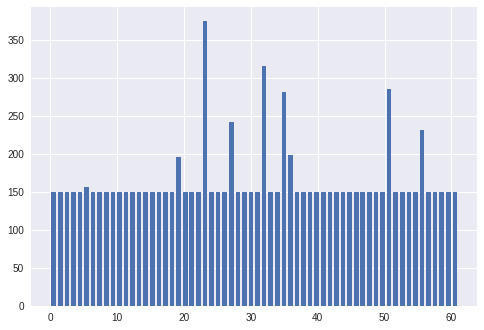

In [19]:
# histogram of label frequency (once again, before data augmentation)
hist, bins = np.histogram(y_train_normalized, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [0]:
def createLeNetModel(num_classes):
  # first set of CONV => RELU => POOL
    model = Sequential()
    model.add(Convolution2D(20, 5, 5,input_shape=(32, 32,3), border_mode="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL
    model.add(Convolution2D(50, 5, 5, border_mode="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(Dropout(0.6))
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(Dropout(0.4))
    # softmax classifier
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    # Compile model
    lrate = 0.01
    decay = lrate/30
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model

In [21]:
#y_train.shape[1
labels = np.array(y_train_normalized)
labels = to_categorical(labels,num_classes=62)
labels.shape[1]        

62

In [22]:
model = createLeNetModel(labels.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 20)        1520      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1638912   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (5, 5), input_shape=(32, 32, 3..., activation="relu", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (5, 5), activation="relu", padding="same")`
  


In [0]:
#model = createLeNetModel(y_train.shape[1])

In [24]:
model.fit(X_train_normalized, labels, validation_split = 0.3, epochs=60)

Train on 7163 samples, validate on 3070 samples
Epoch 1/60
7163/7163 [==============================] - 4s 534us/step - loss: 3.5223 - acc: 0.1381 - val_loss: 4.7403 - val_acc: 6.5147e-04
Epoch 2/60
7163/7163 [==============================] - 2s 321us/step - loss: 2.2103 - acc: 0.3761 - val_loss: 4.8329 - val_acc: 0.0143
Epoch 3/60
7163/7163 [==============================] - 2s 317us/step - loss: 1.5134 - acc: 0.5399 - val_loss: 5.0673 - val_acc: 0.0270
Epoch 4/60
7163/7163 [==============================] - 2s 316us/step - loss: 1.1530 - acc: 0.6439 - val_loss: 4.9829 - val_acc: 0.0368
Epoch 5/60
7163/7163 [==============================] - 2s 318us/step - loss: 0.9025 - acc: 0.7201 - val_loss: 5.1676 - val_acc: 0.0472
Epoch 6/60
7163/7163 [==============================] - 2s 316us/step - loss: 0.7430 - acc: 0.7701 - val_loss: 4.9357 - val_acc: 0.0580
Epoch 7/60
7163/7163 [==============================] - 2s 319us/step - loss: 0.5739 - acc: 0.8173 - val_loss: 5.4049 - val_acc: 0.0

In [25]:
#y_test = 
y_test = np.array(y_test)
y_test = to_categorical(y_test,num_classes=62)
predict = np.argmax(model.predict(X_test), axis = 1)
count = 0
for i in range(0,predict.shape[0]):
    if (predict[i] == np.argmax(y_test[i])):
        count +=1
print ('Accuracy on Test ',100 * count/predict.shape[0],'%')

Accuracy on Test  97.38095238095238 %
